# Supplementary paper figures
Note that Fig S5 is captured in `05a_sc_figures.ipynb`

In [1]:
DATA_DIR = "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/data/"
RESULTS_DIR = "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE =   9  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Classification metrics in more detail

In [24]:
n = 150 # 50 or 150

if n == 50:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection_n50/selections_info.csv",
        index_col=0
    )
    conf_mats = {}
    for set_id, method in set_info["method"].items():
        conf_mats[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/Madissoon_summary.csv",
        index_col=0
    )
elif n == 150:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection/selections_info.csv",
        index_col=0
    )
    conf_mats = {}
    for set_id, method in set_info["method"].items():
        conf_mats[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/Madissoon_summary.csv",
        index_col=0
    )    
    
summary_table["method"] = set_info["method"]

best_set = {}
for method, set_id in summary_table.groupby("method")["knn_overlap mean_overlap_AUC"].idxmax().items():
    best_set[method] = set_id

set_info.loc[[set_id for _, set_id in best_set.items()]]

,method,normalised,log1p,scaled,time_seconds,data_path,dataset,fraction_seed,gene_subset,n,obs_fraction,penalty_keys,absolute,n_pcs,variance_scaled,seed,obs_key,rankby_abs
set_id,,,,,,,,,,,,,,,,,,
selection_6,DE,True,True,False,86.953962,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,NaN,NaN,NaN,NaN,original_celltype_ann,False
selection_17,highest_expr,True,True,False,1.227777,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
selection_18,hvg,True,True,False,4.814159,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
selection_2,pca,True,True,False,10.447994,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,True,25.0,False,NaN,NaN,NaN
selection_7,random,True,True,False,0.003472,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,NaN,NaN,NaN,9394.0,NaN,NaN
selection_19,spca,True,True,False,8418.128429,/storage/groups/ml01/workspace/louis.kuemmerle...,Madissoon2019.h5ad,NaN,highly_variable,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def linear_step(x, low, high, descending=True):
    """Step function with linear transition between low and high
    descending:
        Wether to go from 1 to 0 or the other way around.
    """

    b = 1.0
    m = 1 / (high - low)

    if descending:
        return np.where(x < low, b, np.where(x > high, 0, (x - low) * (-m) + b))
    else:
        return np.where(x < low, 0, np.where(x > high, b, (x - low) * m + 0))

def threshold_on_diagonal_confusion(conf_mat, threshold=0.8, tolerance=0.05):
    """Compute percentage of diagonal elements of confusion matrix above threshold
    To make the metric more stable we smoothen the threshold with a linear transition from
    threshold - tolerance to threshold + tolerance.
    """
    return linear_step(np.diag(conf_mat), threshold - tolerance, threshold + tolerance, descending=False)

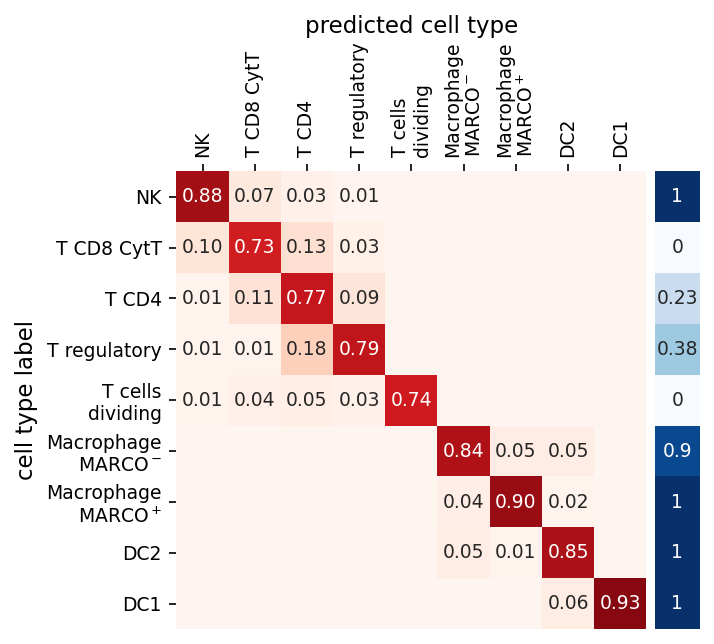

In [25]:
SMALL_SIZE =   9  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


df = conf_mats[best_set["DE"]]
subset_ordered = ["NK","T_CD8_CytT","T_CD4","T_regulatory","T_cells_Dividing",
                  "Macrophage_MARCOneg","Macrophage_MARCOpos","DC_2","DC_1"]
df = df.loc[subset_ordered,subset_ordered]
rename = {
    'T_CD8_CytT'           : 'T CD8 CytT', 
    'T_CD4'                : 'T CD4', 
    'T_regulatory'         : 'T regulatory', 
    'T_cells_Dividing'     : 'T cells\ndividing',
    'Macrophage_MARCOneg'  : 'Macrophage\nMARCO$^-$', 
    'Macrophage_MARCOpos'  : 'Macrophage\nMARCO$^+$', 
    'DC_2'                 : 'DC2', 
    'DC_1'                 : 'DC1'
}
df = df.rename(rename,axis=0)
df = df.rename(rename,axis=1)



################
n = len(df)
vmin=0
vmax=1


fig = plt.figure(figsize=(6 * 0.75, 0.75 * 6 ))#(8,8))
ax1 = plt.subplot2grid((n+1,n+1), (0,0), colspan=n, rowspan=n)
ax2 = plt.subplot2grid((n+1,n+1), (0,n), colspan=1, rowspan=n)

# Annotations
formatter = lambda s: f"{s:.2f}" if (abs(s) > 0.005) else ""
annot = df.applymap(formatter).values

# Heatmap plots
sns.heatmap(df, ax=ax1, cmap="Reds",#"YlOrRd",#mask=mask,
            linecolor='b', cbar = False, annot=annot, fmt="",
            vmin=vmin,vmax=vmax)

sns.heatmap(pd.DataFrame(index=df.index,data=threshold_on_diagonal_confusion(df, threshold=0.8, tolerance=0.05)),#pd.DataFrame(df.sum(axis=1)), 
            ax=ax2,  annot=True, cmap="Blues", 
            cbar=False, xticklabels=False, yticklabels=False,
            vmin=vmin,vmax=vmax)

# Ticks and labels
ax1.xaxis.tick_top()
ax1.set_xticklabels(df.columns,rotation=40)
plt.sca(ax1)
plt.tick_params(axis="both", which="major", bottom=False, labelbottom=False, top=True, labeltop=True)
plt.setp(plt.gca().get_xticklabels(), ha="center", ma="left", rotation=90)# ha="left", rotation=45)
plt.xlabel("predicted cell type")
ax1.xaxis.set_label_position('top')
plt.ylabel("cell type label")

# Show and save
plt.show()
#fig.savefig(f"./figures/Suppl_ct_clfs_{method}.png", bbox_inches="tight")
#plt.close()



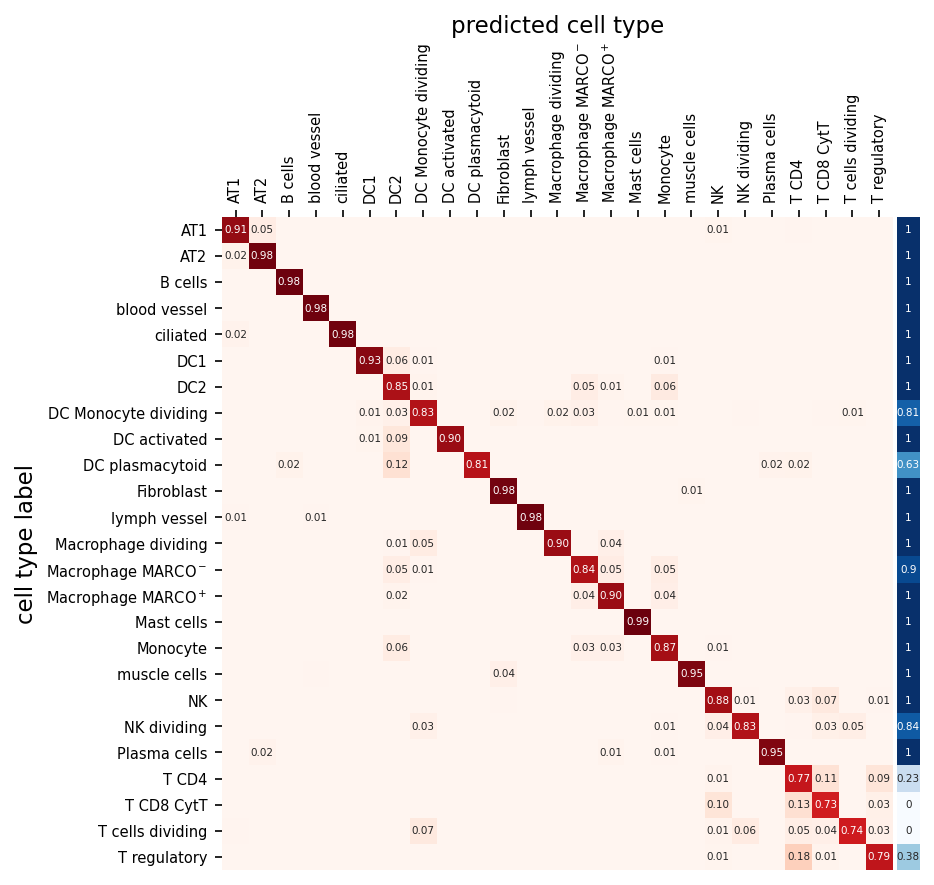

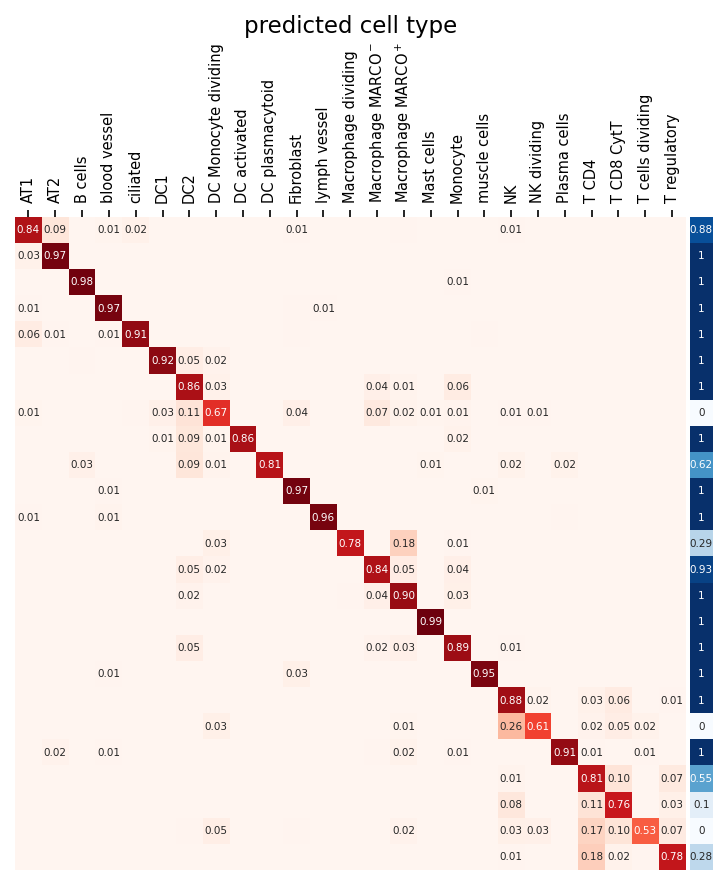

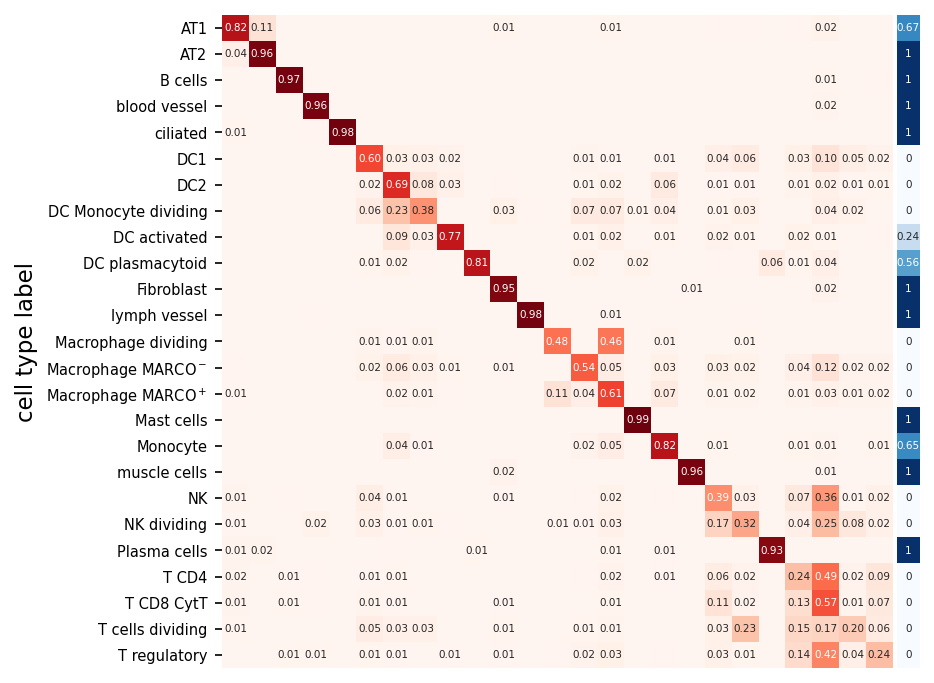

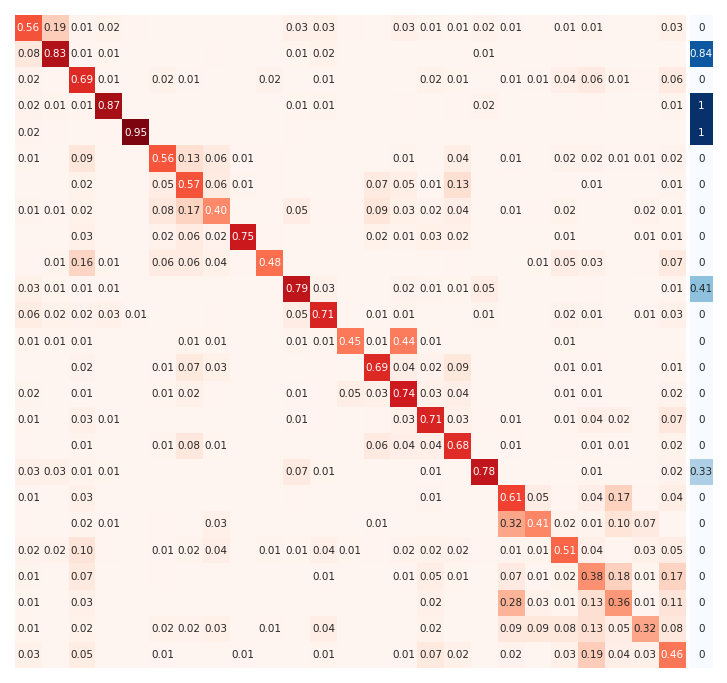

In [30]:
SMALL_SIZE =   5  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ncols = 2 # note we don't have a full figure with subfigures but for according ncols we leave out x or y ticks or both or none

for m_idx, method in enumerate(["DE","pca","hvg","random"]):

    df = conf_mats[best_set[method]]
    rename = {
        'Alveolar_Type1'       :"AT1",
        'Alveolar_Type2'       :"AT2",
        'B_cells'              :"B cells",
        'Blood_vessel'         :"blood vessel",
        'Ciliated'             :"ciliated",
        'DC_1'                 :"DC1",
        'DC_2'                 :"DC2",
        'DC_Monocyte_Dividing' :"DC Monocyte dividing",
        'DC_activated'         :"DC activated",
        'DC_plasmacytoid'      :"DC plasmacytoid",
        'Fibroblast'           :"Fibroblast",
        'Lymph_vessel'         :"lymph vessel",
        'Macrophage_Dividing'  :"Macrophage dividing",
        'Macrophage_MARCOneg'  :"Macrophage MARCO$^-$",
        'Macrophage_MARCOpos'  :"Macrophage MARCO$^+$",
        'Mast_cells'           :"Mast cells",
        'Monocyte'             :"Monocyte",
        'Muscle_cells'         :"muscle cells",
        'NK'                   :"NK",
        'NK_Dividing'          :"NK dividing",
        'Plasma_cells'         :"Plasma cells",
        'T_CD4'                :"T CD4",
        'T_CD8_CytT'           :"T CD8 CytT",
        'T_cells_Dividing'     :"T cells dividing",
        'T_regulatory'         :"T regulatory",
    }
    df = df.loc[[key for key in rename],[key for key in rename]]
    df = df.rename(rename,axis=0)
    df = df.rename(rename,axis=1)
    
    
    
    ################
    n = len(df)
    vmin=0
    vmax=1
    
    
    fig = plt.figure(figsize=(6, 6 ))#(8,8))
    ax1 = plt.subplot2grid((n+1,n+1), (0,0), colspan=n, rowspan=n)
    ax2 = plt.subplot2grid((n+1,n+1), (0,n), colspan=1, rowspan=n)
    
    # Annotations
    formatter = lambda s: f"{s:.2f}" if (abs(s) > 0.005) else ""
    annot = df.applymap(formatter).values
    
    # Heatmap plots
    sns.heatmap(df, ax=ax1, cmap="Reds",#"YlOrRd",#mask=mask,
                linecolor='b', cbar = False, annot=annot, fmt="",
                vmin=vmin,vmax=vmax)
    
    sns.heatmap(pd.DataFrame(index=df.index,data=threshold_on_diagonal_confusion(df, threshold=0.8, tolerance=0.05)),#pd.DataFrame(df.sum(axis=1)), 
                ax=ax2,  annot=True, cmap="Blues", 
                cbar=False, xticklabels=False, yticklabels=False,
                vmin=vmin,vmax=vmax)
    
    # Ticks and labels
    plt.sca(ax1)    
    ax1.xaxis.tick_top()
    if m_idx < ncols:
        ax1.set_xticklabels(df.columns,rotation=40)
        plt.xlabel("predicted cell type")        
    else:
        ax1.get_xaxis().set_ticks([])
        plt.xlabel("")

    plt.tick_params(axis="both", which="major", bottom=False, labelbottom=False, top=True, labeltop=True, labelsize=7)
    plt.setp(plt.gca().get_xticklabels(), ha="center", ma="left", rotation=90)# ha="left", rotation=45)
    ax1.xaxis.set_label_position('top')
    if (m_idx%ncols == 0):
        plt.ylabel("cell type label")
    else:
        plt.ylabel("")
        ax1.get_yaxis().set_ticks([])
    
    # Show and save
    fig.savefig(f"./figures/Suppl_ct_clfs_n{n}_{method}.png", bbox_inches="tight", transparent=True)
    plt.show()    
    #plt.close()

# marker correlation in more detail

In [4]:
n = 150 # 50 or 150

if n == 50:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection_n50/selections_info.csv",
        index_col=0
    )
    marker_corr = {}
    for set_id, method in set_info["method"].items():
        marker_corr[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/marker_corr/marker_corr_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/Madissoon_summary.csv",
        index_col=0
    )
elif n == 150:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection/selections_info.csv",
        index_col=0
    )
    marker_corr = {}
    for set_id, method in set_info["method"].items():
        marker_corr[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/marker_corr/marker_corr_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/Madissoon_summary.csv",
        index_col=0
    )
    
summary_table["method"] = set_info["method"]

set_info = set_info.loc[~set_info["scaled"]]
summary_table = summary_table.loc[set_info.index]

best_set = {}
for method, set_id in summary_table.groupby("method")["marker_corr per celltype"].idxmax().items():
    best_set[method] = set_id

set_info["marker_corr per celltype"] = summary_table.loc[set_info.index,"marker_corr per celltype"]

set_info = set_info.loc[[set_id for _, set_id in best_set.items()]].sort_values("marker_corr per celltype",ascending=False)

In [5]:
# Get genes in correct order
tmp = marker_corr[set_info.index[0]]
tmp["genes"] = tmp.index
tmp = tmp.sort_values(["celltype","genes"])
tmp = tmp.loc[~tmp["per marker mean > 0.025"].isnull()]
genes = tmp["genes"].values

# Create dataframe for heatmap
df = pd.DataFrame(
    index = set_info["method"].values,#.index,
    data = {gene:[marker_corr[set_id].loc[gene,"per marker mean > 0.025"] for set_id in set_info.index] for gene in genes}
)
# This one didn't work since `per celltype` took into account `per marker` instead of `per marker mean > 0.025` so some cell types didn't have the max gene
#df_masked = pd.DataFrame(
#    index = set_info["method"].values,#.index,
#    data = {gene:[marker_corr[set_id].loc[gene,"per celltype"] for set_id in set_info.index] for gene in genes}
#)
df_masked = df.copy()
for ct in tmp["celltype"].unique():
    genes_tmp = tmp.loc[tmp["celltype"]==ct].index.tolist()
    for method, max_val in df[genes_tmp].max(axis=1).items():
        genes_reduced = [g for g in genes_tmp if (df.loc[method,g] != max_val)]
        df_masked.loc[method,genes_reduced] = np.nan

In [8]:
marker_corr["selection_20"]

,celltype,mean,per marker,per celltype,per marker mean > 0.025
ACTA2,Pericytes airway,0.142630,1.000000,1.0,1.000000
AGER,AT1,0.024392,0.289786,NaN,NaN
AIF1,Alv Macrophage,0.534544,0.640906,NaN,0.640906
AIM2,B cells,0.014289,0.070384,NaN,NaN
APOBEC3A,Monocytes,0.026339,0.136384,NaN,0.136384
...,...,...,...,...,...
VAMP2,Brush/Tuft cells,0.472240,0.041947,NaN,0.041947
VCAN,Monocytes,0.255437,0.140677,NaN,0.140677
VPREB3,B cells,0.017251,0.141002,NaN,NaN
VSIG4,Alv Macrophage,0.197979,0.694846,NaN,0.694846


In [6]:
df

,AQP4,NAPSA,SFTPA1,SFTPA2,SFTPB,SFTPC,SFTPD,AIF1,APOC1,CCL18,...,CD24,CHI3L1,ACTA2,RGS5,TAGLN,LYZ,SPRR3,FKBP11,JCHAIN,MZB1
DE,0.651206,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.584729,...,0.372986,0.564093,1.000000,0.327471,1.000000,1.00000,0.105214,1.000000,1.000000,1.000000
hvg,0.651206,0.877806,1.000000,1.000000,1.000000,0.835395,0.887993,0.501114,0.564411,0.512967,...,0.372986,0.543813,1.000000,1.000000,0.695028,0.67862,0.408202,0.225598,1.000000,1.000000
pca,0.630639,0.859160,1.000000,1.000000,1.000000,1.000000,0.860883,1.000000,1.000000,0.584729,...,0.130309,0.525692,1.000000,0.272570,1.000000,1.00000,0.124995,0.154162,0.411214,0.386811
spca,0.651206,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.584729,...,0.151208,0.564093,0.327862,0.271013,0.408669,1.00000,0.148014,0.154162,0.067400,0.038738
highest_expr,0.630639,0.859160,1.000000,1.000000,1.000000,1.000000,0.860883,1.000000,0.621428,0.568625,...,0.071531,0.525692,0.327862,0.271013,0.408669,1.00000,0.105214,0.154162,0.136016,0.133710
random,0.617702,0.845554,0.822375,0.822342,0.838673,0.777526,0.844055,0.726704,0.374759,0.293510,...,0.344037,0.482916,0.300333,0.324869,0.318155,1.00000,0.215757,0.132066,0.293068,0.267251


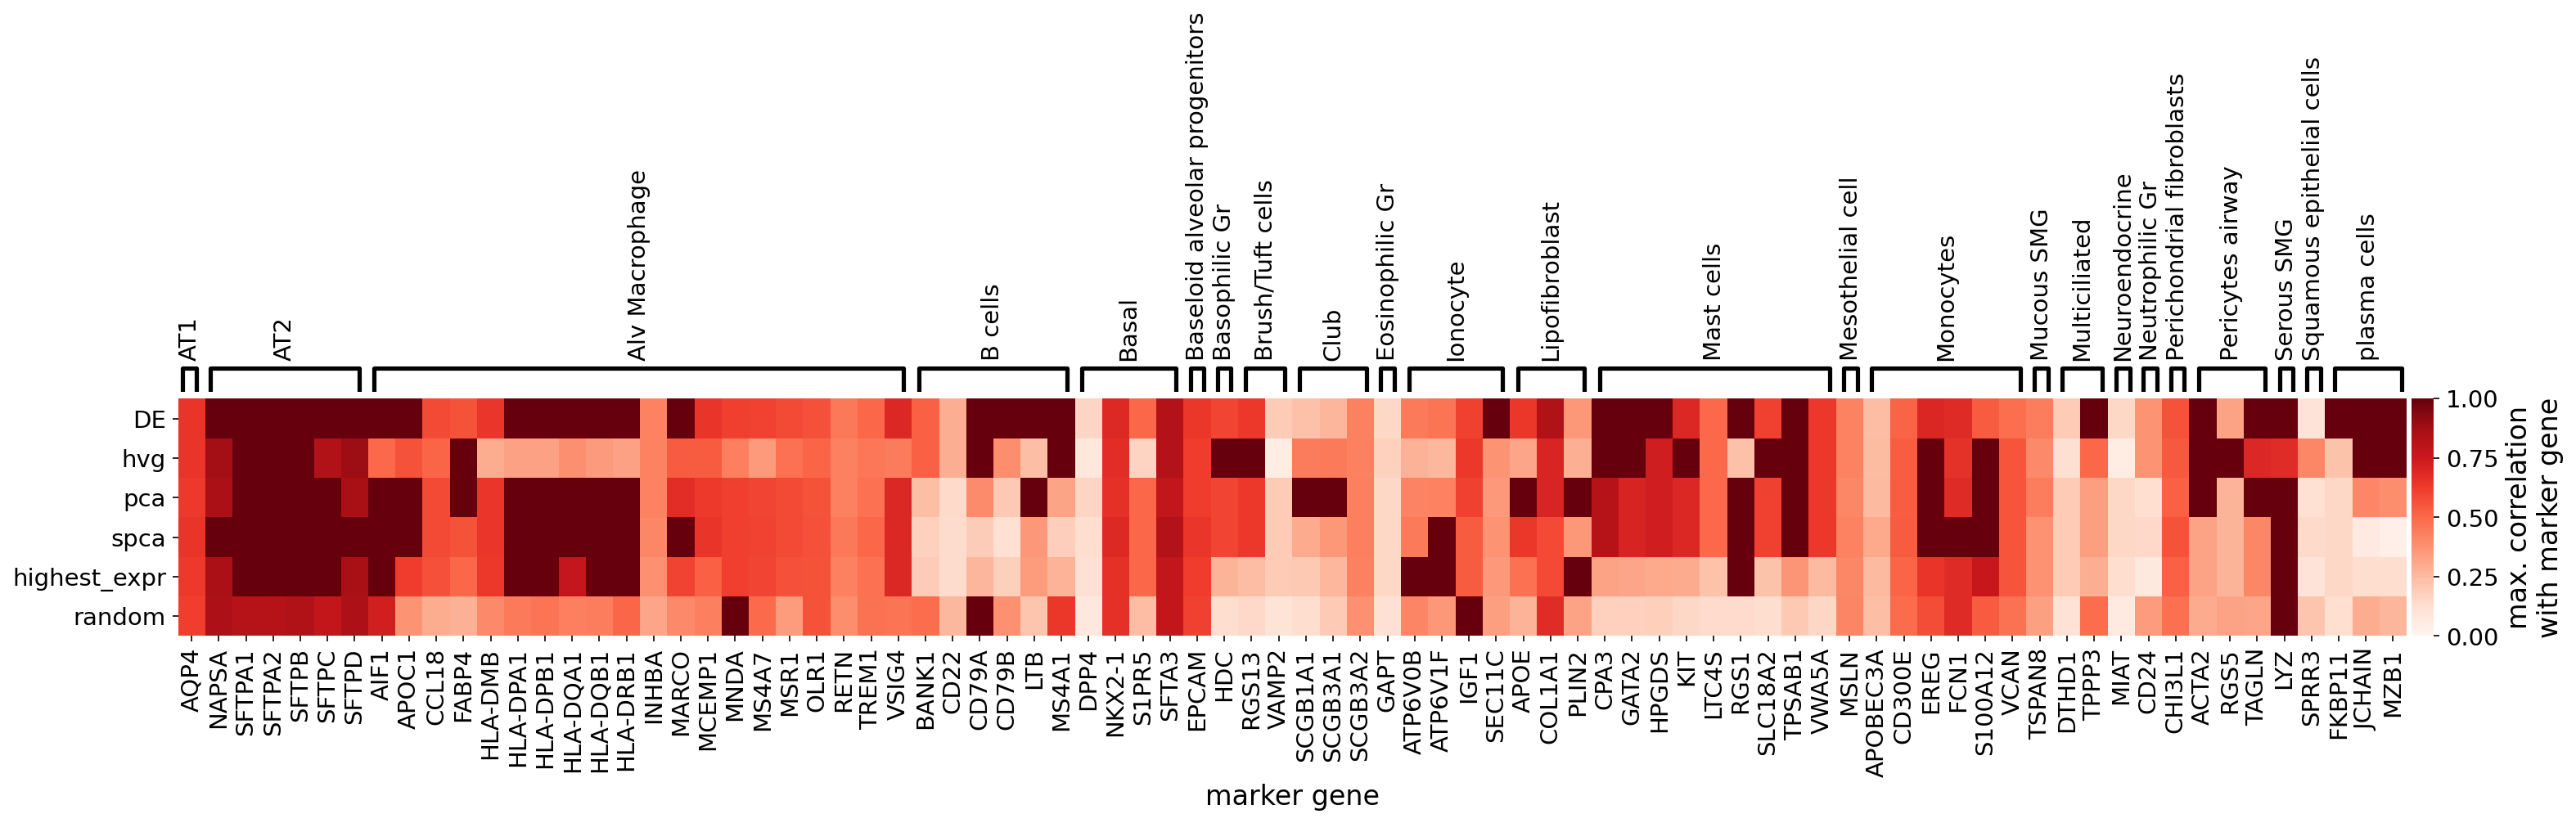

In [116]:
SMALL_SIZE =  14  #17
MEDIUM_SIZE = 16  #19
BIGGER_SIZE = 18  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

s_factor = 2

pos_factor = 0.02
group_positions = []
group_labels = []
for ct in tmp["celltype"].unique():
    tmptmp = pd.Series((tmp["celltype"] == ct).values)
    #group_positions.append([tmptmp.idxmax()*pos_factor,tmptmp.where(tmptmp).last_valid_index()*pos_factor])
    group_positions.append([tmptmp.idxmax(),tmptmp.where(tmptmp).last_valid_index()])
    group_labels.append(ct)

fig = plt.figure(figsize=(12*s_factor, 1.5*s_factor))#(8,8))
ncols_genes = len(df.columns)
ncols_cbar = max(int(0.03 * ncols),1)
ncols = ncols_genes + ncols_cbar
nrows = len(df) + 1

#gene_groups_ax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=1)
ax1 = plt.subplot2grid((nrows,ncols), (1,0), colspan=ncols_genes, rowspan=nrows-1)
ax2 = plt.subplot2grid((nrows,ncols), (1,ncols_genes), colspan=1, rowspan=nrows-1)

sns.heatmap(df,square=False,cbar_ax=ax2,ax=ax1,cmap="Reds",vmin=0,vmax=1,annot=False)


for g_idx,group in enumerate(group_labels):
    n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
    #n_cols_group = group[1][1] - group[1][0] + 1
    ax = plt.subplot2grid((nrows,ncols), (0,group_positions[g_idx][0]), colspan=n_cols_group, rowspan=1)
    
    #ax = plt.subplot(gs1[0,group[1][0]:group[1][1]+1])
    ax.axis('off')
    ax.set_xlim([0,n_cols_group])
    ax.set_ylim([0,1])
    x1 , x2 = [0.2 , n_cols_group-0.2]
    y , h = [0,0.7]#[0,0.12]#[0,0.3]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c="black")
    plt.text((x1+x2)*.5, (y+h)*1.3, group, ha='center', va='bottom', color="black", rotation=90)#, fontsize=fsize)

ax1.set_xlabel("marker gene")
ax2.set_ylabel("max. correlation\nwith marker gene")

fig.savefig(f"./figures/Suppl_marker_corr_n{n}.png", bbox_inches="tight", transparent=True)
plt.show()

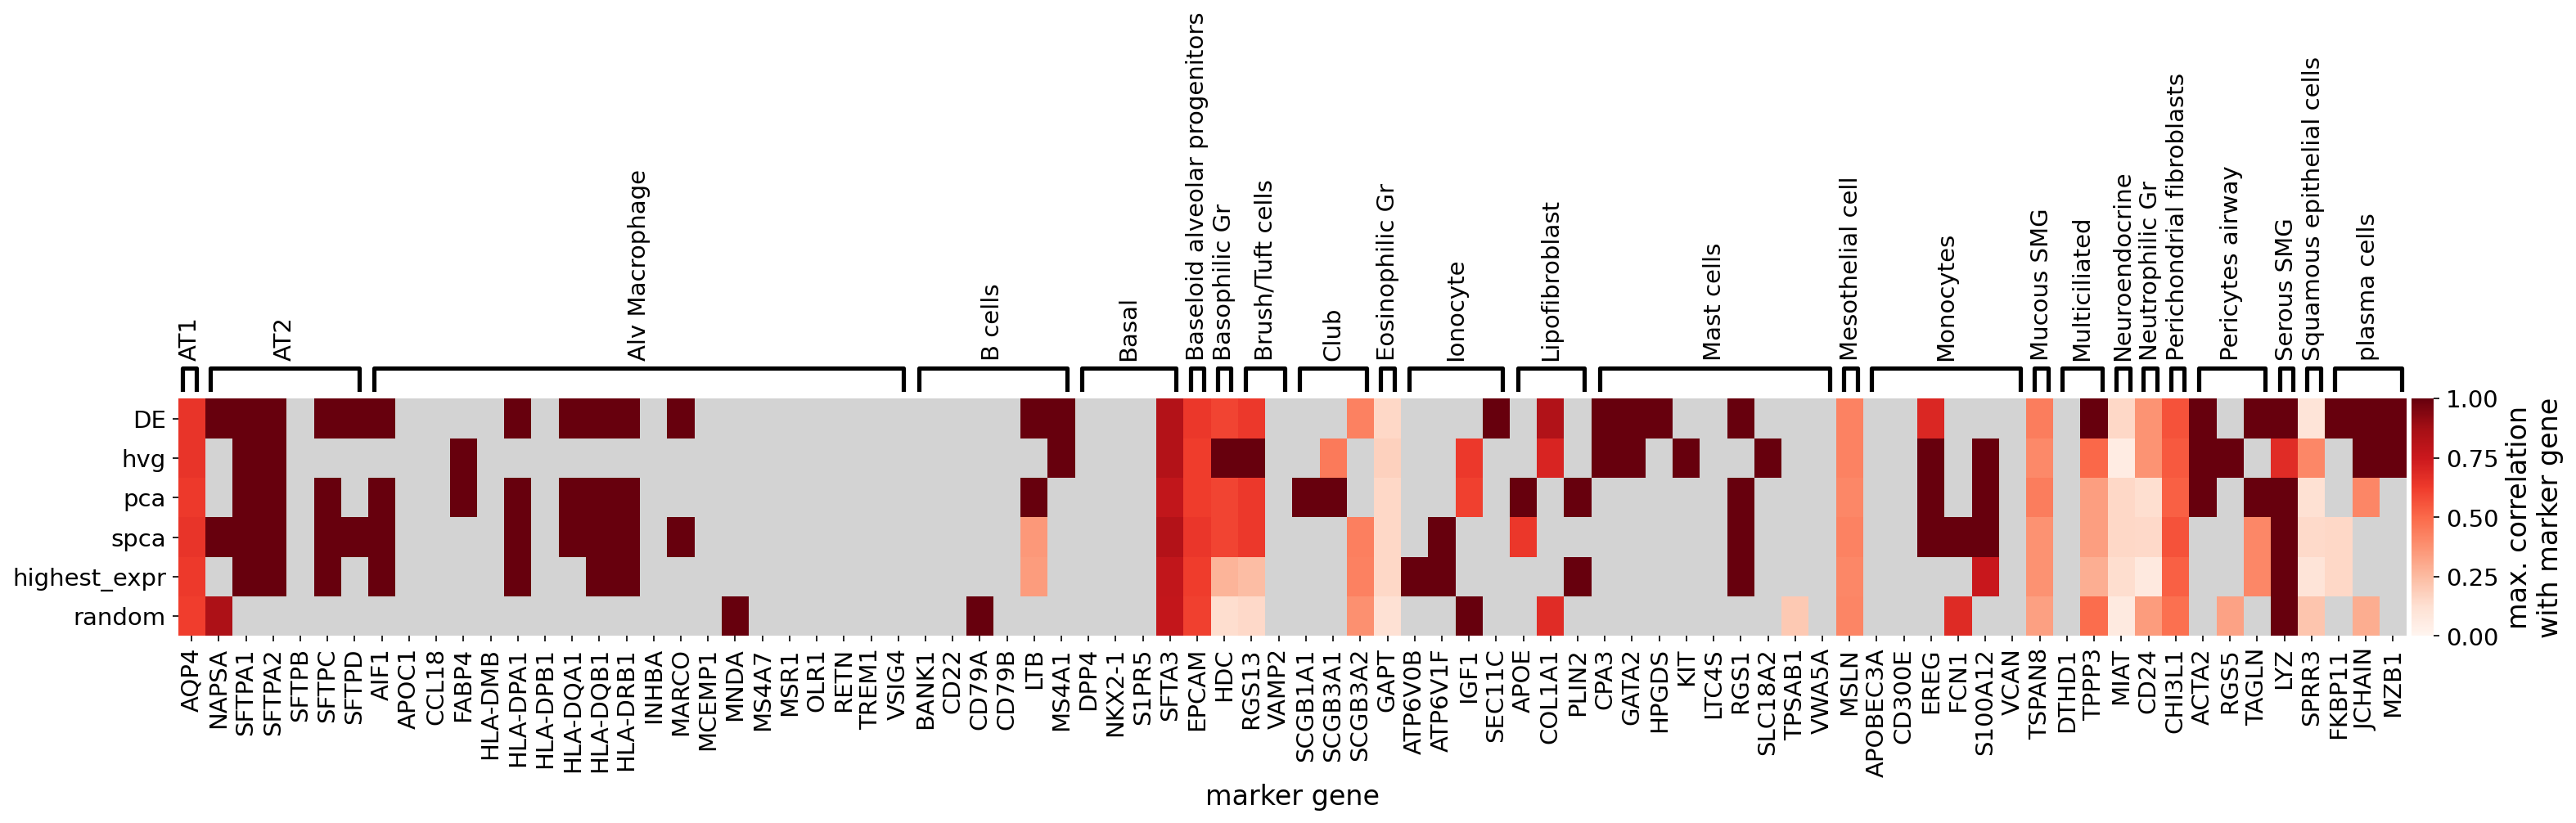

In [118]:
SMALL_SIZE =  14  #17
MEDIUM_SIZE = 16  #19
BIGGER_SIZE = 18  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

s_factor = 2

pos_factor = 0.02
group_positions = []
group_labels = []
for ct in tmp["celltype"].unique():
    tmptmp = pd.Series((tmp["celltype"] == ct).values)
    #group_positions.append([tmptmp.idxmax()*pos_factor,tmptmp.where(tmptmp).last_valid_index()*pos_factor])
    group_positions.append([tmptmp.idxmax(),tmptmp.where(tmptmp).last_valid_index()])
    group_labels.append(ct)

fig = plt.figure(figsize=(12*s_factor, 1.5*s_factor))#(8,8))
ncols_genes = len(df.columns)
ncols_cbar = max(int(0.03 * ncols),1)
ncols = ncols_genes + ncols_cbar
nrows = len(df) + 1

#gene_groups_ax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=1)
ax1 = plt.subplot2grid((nrows,ncols), (1,0), colspan=ncols_genes, rowspan=nrows-1)
ax2 = plt.subplot2grid((nrows,ncols), (1,ncols_genes), colspan=1, rowspan=nrows-1)

hm = sns.heatmap(df_masked,square=False,cbar_ax=ax2,ax=ax1,cmap="Reds",vmin=0,vmax=1,annot=False,)
hm.set_facecolor('lightgrey')#'xkcd:lightgrey')

for g_idx,group in enumerate(group_labels):
    n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
    #n_cols_group = group[1][1] - group[1][0] + 1
    ax = plt.subplot2grid((nrows,ncols), (0,group_positions[g_idx][0]), colspan=n_cols_group, rowspan=1)
    
    #ax = plt.subplot(gs1[0,group[1][0]:group[1][1]+1])
    ax.axis('off')
    ax.set_xlim([0,n_cols_group])
    ax.set_ylim([0,1])
    x1 , x2 = [0.2 , n_cols_group-0.2]
    y , h = [0,0.7]#[0,0.12]#[0,0.3]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c="black")
    plt.text((x1+x2)*.5, (y+h)*1.3, group, ha='center', va='bottom', color="black", rotation=90)#, fontsize=fsize)

ax1.set_xlabel("marker gene")
ax2.set_ylabel("max. correlation\nwith marker gene")

fig.savefig(f"./figures/Suppl_marker_corr_n{n}_masked.png", bbox_inches="tight")#, transparent=True)
plt.show()

# Variation recovery metrics in more detail

In [177]:
n = 150 # 50 or 150

if n == 50:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection_n50/selections_info.csv",
        index_col=0
    )
    cluster_sim = {}
    for set_id, method in set_info["method"].items():
        cluster_sim[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/cluster_similarity/cluster_similarity_Madissoon_{set_id}.csv",
            index_col=0
        )
    knn_overlap = {}
    for set_id, method in set_info["method"].items():
        knn_overlap[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/knn_overlap/knn_overlap_Madissoon_{set_id}.csv",
            index_col=0
        )        
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/Madissoon_summary.csv",
        index_col=0
    )
elif n == 150:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection/selections_info.csv",
        index_col=0
    )
    cluster_sim = {}
    for set_id, method in set_info["method"].items():
        cluster_sim[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/cluster_similarity/cluster_similarity_Madissoon_{set_id}.csv",
            index_col=0
        )
    knn_overlap = {}
    for set_id, method in set_info["method"].items():
        knn_overlap[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/knn_overlap/knn_overlap_Madissoon_{set_id}.csv",
            index_col=0
        )         
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/Madissoon_summary.csv",
        index_col=0
    )
    
summary_table["method"] = set_info["method"]

set_info = set_info.loc[~set_info["scaled"]]
set_info = set_info.loc[(set_info["n_pcs"].isnull() | (set_info["n_pcs"] == 20.0))]
cluster_sim = {key:cluster_sim[key] for key in set_info.index}
knn_overlap = {key:knn_overlap[key] for key in set_info.index}


In [181]:
from typing import Dict, Any, Callable, List, Literal, Optional, Tuple, Union

def cluster_similarity(
    selections_info: pd.DataFrame,
    nmi_dfs: Optional[Dict[str, pd.DataFrame]] = None,
    groupby: Optional[str] = None,
    interpolate: bool = True,
    figsize: Tuple[int, int] = (10, 6),
    fontsize: int = 18,
    title: Optional[str] = None,
    show: bool = True,
    save: Optional[str] = None,
):
    """Plot normalized mutual information of clusterings over number of clusters.
    Args:
        selections_info:
            Information on each selection for plotting. The dataframe includes:
                - selection ids or alternative names as index
                - mandatory (only if ``nmi_dfs=None``) column: `path`: path to results csv of each selection (contains
                  number of clusters and nmi values (as index) and nmi values in column `nmi`.)
                - optional columns (Note that the legend order will follow the row order in :attr:`selections_info`.):
                    - `color`: matplotlib color
                    - `linewidth`: matplotlib linewidth
                    - `linestyle`: matplotlib linestyle
                    - `<groupby>`: some annotation that can be used to group the legend.
        nmi_dfs:
            NMI results for each selection.
        groupby:
            Column in ``selections_info`` to group the legend.
        interpolate
            Whether to interpolate the NMI values.
        figsize:
            Matplotlib figsize.
        fontsize:
            Matplotlib fontsize.
        title:
            Plot title.
        show:
            Whether to display the plot.
        save:
            Save the plot to path.
    Returns:
        Figure can be shown (default `True`) and stored to path (default `None`).
        Change this with ``show`` and ``save``.
    """

    # TODO: nmi_dfs: Check if it's useful to add this or if we always should load from files
    #  (or maybe even the other way around?)
    # TODO: instead of a list we could also use one dataframe with index: ns, column_names: probeset_ids,
    #       Check what's more practical, (think wrt Evaluator.plot_cluster_similarity())
    #  ==> my suggestion: dict of dfs just like evaluator.results["cluster_similarity"]

    df = selections_info.copy()

    # load NMI values from files if necessary
    if nmi_dfs is None:
        if "path" not in df:
            raise ValueError("The mandatory column 'path' is missing in 'selections_info'.")
        else:  # load NMI values from files
            nmi_dfs = {}
            for selection_nr, path in enumerate(df["path"]):
                nmi_dfs[str(selection_nr)] = pd.read_csv(path, index_col=0)
            # del df["path"]

    # check matplotlib style options
    for col in ["color", "linewidth", "linestyle"]:
        if col not in df.columns:
            df[col] = None
    if groupby:
        group_check = df[["color", "linewidth", "linestyle",groupby]].groupby(by=groupby).nunique() > 1
        if group_check.any().any():
            bad_group = group_check[group_check].dropna(how="all").dropna(how="all", axis=1)
            raise ValueError(
                "Grouping by "
                + groupby
                + " failed because the values of "
                + str(bad_group.columns.values)
                + " are not unique for group(s) "
                + str(bad_group.index.values)
                + "."
            )

    fig = plt.figure(figsize=figsize)

    labels = []

    for selection_id, plot_df in nmi_dfs.items():
        label = selection_id if not groupby else df.loc[selection_id][groupby]

        plt.plot(
            plot_df["nmi"].interpolate() if interpolate else plot_df["nmi"],
            c=df.loc[selection_id]["color"],
            lw=df.loc[selection_id]["linewidth"],
            linestyle=df.loc[selection_id]["linestyle"],
            label=None if label in labels else label,
        )

        labels.append(label)

    if title:
        plt.title(title, fontsize=fontsize)

    plt.xlabel("number of clusters", fontsize=fontsize)
    #plt.ylabel("NMI", fontsize=fontsize)
    plt.ylabel("normalized mutual information between\nclusterings on probeset and reference", fontsize=fontsize)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=fontsize)

    plt.tick_params(axis="both", labelsize=fontsize)

    
    plt.axvline(x=7,linestyle=":", color="grey", linewidth=1)
    plt.axvline(x=20.5,linestyle=":", color="grey", linewidth=1)
    plt.axvline(x=60,linestyle=":", color="grey", linewidth=1)
    
    
    plt.tight_layout()
    if show:
        plt.show()
    if save:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    plt.close()


def knn_overlap_plot(
    selections_info: pd.DataFrame,
    knn_dfs: Optional[Dict[str, pd.DataFrame]] = None,
    groupby: Optional[str] = None,
    interpolate: bool = True,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 6),
    fontsize: int = 18,
    show: bool = True,
    save: Optional[str] = None,
):
    """Plot plot mean overlap of knn clusterings over number of clusters.
    Args:
        selections_info:
            Information on each selection for plotting. The dataframe includes:
                - selection ids or alternative names as index
                - mandatory (only if ``nmi_dfs=None``) column: `path`: path to results csv of each selection (contains
                  number of clusters and nmi values (as index) and nmi values in column `nmi`.)
                - optional columns (Note that the legend order will follow the row order in :attr:`selections_info`.):
                    - `color`: matplotlib color
                    - `linewidth`: matplotlib linewidth
                    - `linestyle`: matplotlib linestyle
                    - `<groupby>`: some annotation that can be used to group the legend.
        knn_dfs:
            NMI results for each selection.
        groupby:
            Column in ``selections_info`` to group the legend.
        interpolate
            Whether to interpolate the NMI values.
        title:
            Plot title.
        figsize:
            Matplotlib figsize.
        fontsize:
            Matplotlib fontsize.
        show:
            Whether to display the plot.
        save:
            Save the plot to path.
    Returns:
        Figure can be shown (default `True`) and stored to path (default `None`).
        Change this with ``show`` and ``save``.
    """

    # TODO: nmi_dfs: Check if it's useful to add this or if we always should load from files
    #  (or maybe even the other way around?)
    # TODO: instead of a list we could also use one dataframe with index: ns, column_names: probeset_ids,
    #       Check what's more practical, (think wrt Evaluator.plot_cluster_similarity())
    #  ==> my suggestion: dict of dfs just like evaluator.results["cluster_similarity"]

    df = selections_info.copy()

    # load NMI values from files if necessary
    if knn_dfs is None:
        if "path" not in df:
            raise ValueError("The mandatory column 'path' is missing in 'selections_info'.")
        else:  # load NMI values from files
            knn_dfs = {}
            for selection_nr, path in enumerate(df["path"]):
                knn_dfs[str(selection_nr)] = pd.read_csv(path, index_col=0)

    # check matplotlib style options
    for col in ["color", "linewidth", "linestyle"]:
        if col not in df.columns:
            df[col] = None
    if groupby:
        group_check = df[["color", "linewidth", "linestyle",groupby]].groupby(by=groupby).nunique() > 1
        if group_check.any().any():
            bad_group = group_check[group_check].dropna(how="all").dropna(how="all", axis=1)
            raise ValueError(
                "Grouping by "
                + groupby
                + " failed because the values of "
                + str(bad_group.columns.values)
                + " are not unique for group(s) "
                + str(bad_group.index.values)
                + "."
            )

    fig = plt.figure(figsize=figsize)

    labels = []

    for selection_id, plot_df in knn_dfs.items():
        label = selection_id if not groupby else df.loc[selection_id][groupby]

        plt.plot(
            plot_df["mean"].interpolate() if interpolate else plot_df["mean"],
            c=df.loc[selection_id]["color"],
            lw=df.loc[selection_id]["linewidth"],
            linestyle=df.loc[selection_id]["linestyle"],
            label=None if label in labels else label,
        )

        labels.append(label)

    if title:
        plt.title()

    plt.xlabel("number of neighbors", fontsize=fontsize)
    #plt.ylabel("mean knn overlap", fontsize=fontsize)
    plt.ylabel("mean knn overlap between\nprobeset and reference", fontsize=fontsize)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=fontsize)
    plt.tick_params(axis="both", labelsize=fontsize)

    plt.tight_layout()
    if show:
        plt.show()
    if save:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    plt.close()

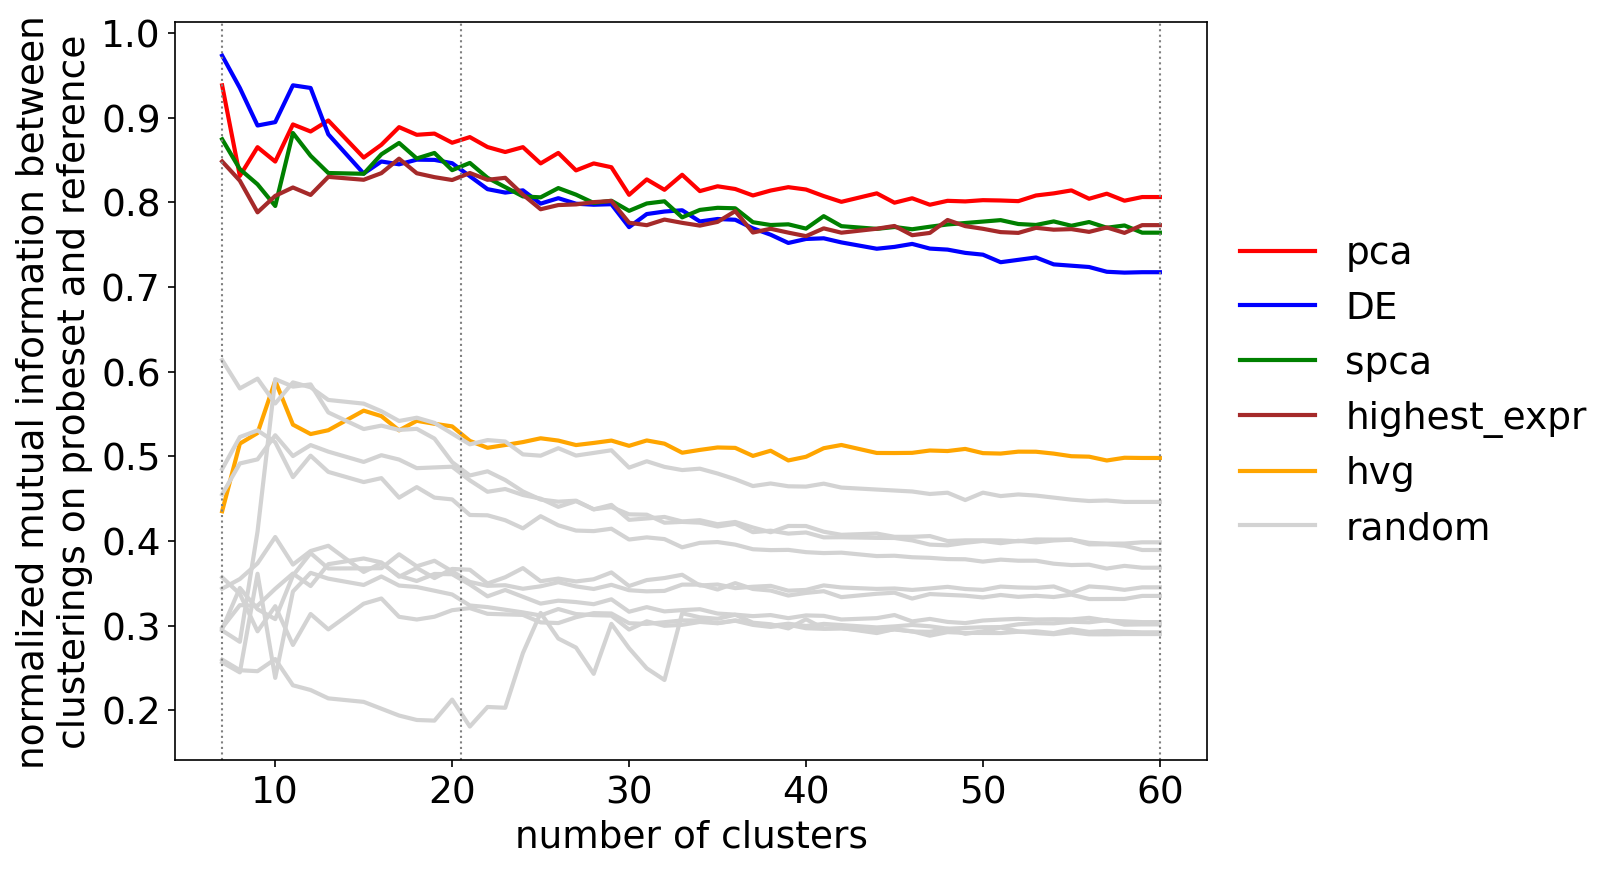

In [182]:
method_to_color = {
    "DE": "blue",
    "pca": "red",
    "spca": "green",
    "highest_expr": "brown",
    "hvg": "orange",
    "random": "lightgrey",
}
method_order = ["pca","DE","spca","highest_expr","hvg","random"]

set_info["linewidth"] = 2

set_info["color"] = set_info["method"].apply(lambda m:method_to_color[m])
set_info["method_order"] = set_info["method"].apply(lambda m:method_order.index(m))
set_info = set_info.sort_values("method_order")
cluster_sim = {key:cluster_sim[key] for key in set_info.index}

cluster_similarity(
    set_info,
    cluster_sim,
    groupby = "method",
    interpolate = True,
    figsize = (11, 6),
    fontsize = 18,
    title = None,
    show = True,
    save = f"./figures/Suppl_cluster_similarity_n{n}.png",
)

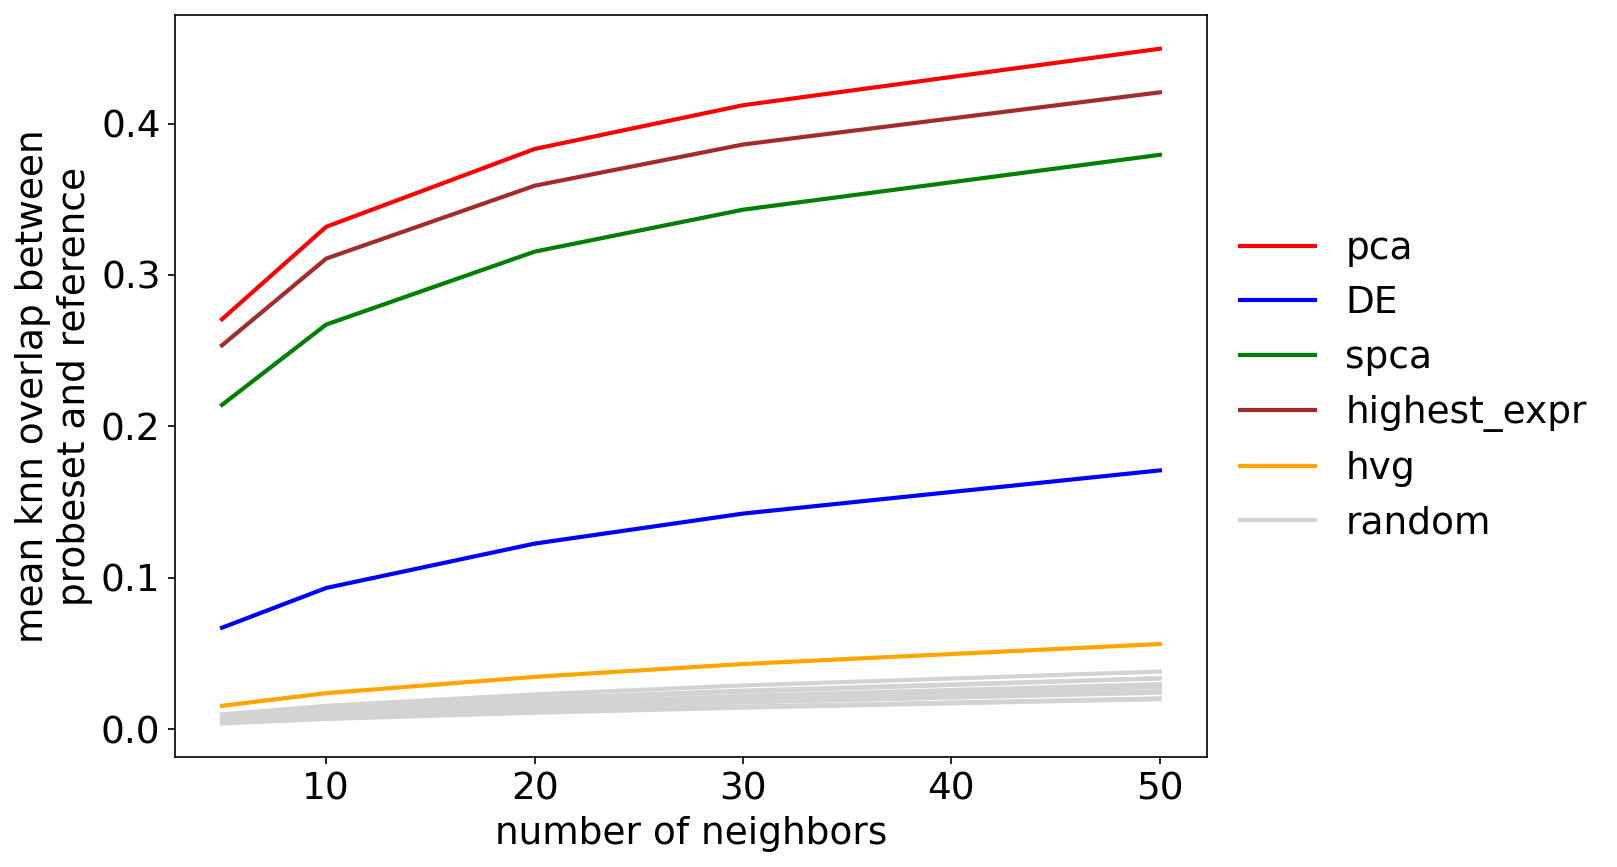

In [183]:
method_to_color = {
    "DE": "blue",
    "pca": "red",
    "spca": "green",
    "highest_expr": "brown",
    "hvg": "orange",
    "random": "lightgrey",
}
method_order = ["pca","DE","spca","highest_expr","hvg","random"]

set_info["linewidth"] = 2

set_info["color"] = set_info["method"].apply(lambda m:method_to_color[m])
set_info["method_order"] = set_info["method"].apply(lambda m:method_order.index(m))
set_info = set_info.sort_values("method_order")
knn_overlap = {key:knn_overlap[key] for key in set_info.index}

knn_overlap_plot(
    set_info,
    knn_overlap,
    groupby = "method",
    interpolate = True,
    figsize = (11, 6),
    fontsize = 18,
    title = None,
    show = True,
    save = f"./figures/Suppl_knn_overlap_n{n}.png",
)

# Gene correlation

In [213]:
n = 150 # 50 or 150

if n == 50:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection_n50/selections_info.csv",
        index_col=0
    )
    gene_corr = {}
    for set_id, method in set_info["method"].items():
        gene_corr[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/gene_corr/gene_corr_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation_n50/Madissoon_summary.csv",
        index_col=0
    )
elif n == 150:
    set_info = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_selection/selections_info.csv",
        index_col=0
    )
    gene_corr = {}
    for set_id, method in set_info["method"].items():
        gene_corr[set_id] = pd.read_csv(
            #f"/home/icb/louis.kuemmerle/projects/st_probesets/experiments/scripts/results/Fig2be_evaluation/forest_clfs/forest_clfs_Madissoon_{set_id}.csv",
            f"/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/gene_corr/gene_corr_Madissoon_{set_id}.csv",
            index_col=0
        )
        
    summary_table = pd.read_csv(
        "/storage/groups/ml01/workspace/louis.kuemmerle/projects/G1/experiments/results/FSmethods_evaluation/Madissoon_summary.csv",
        index_col=0
    )
    
summary_table["method"] = set_info["method"]

set_info = set_info.loc[~set_info["scaled"]]
set_info = set_info.loc[(set_info["n_pcs"].isnull() | (set_info["n_pcs"] == 20.0))]
gene_corr = {key:gene_corr[key] for key in set_info.index}
summary_table = summary_table.loc[set_info.index]



best_set = {}
for method, set_id in summary_table.groupby("method")["gene_corr 1 - mean"].idxmax().items():
    best_set[method] = set_id

set_info["gene_corr 1 - mean"] = summary_table.loc[set_info.index,"gene_corr 1 - mean"]

set_info = set_info.loc[[set_id for _, set_id in best_set.items()]].sort_values("gene_corr 1 - mean",ascending=False)

In [203]:
def linear_step(x, low, high, descending=True):
    """Step function with linear transition between low and high
    descending:
        Wether to go from 1 to 0 or the other way around.
    """

    b = 1.0
    m = 1 / (high - low)

    if descending:
        return np.where(x < low, b, np.where(x > high, 0, (x - low) * (-m) + b))
    else:
        return np.where(x < low, 0, np.where(x > high, b, (x - low) * m + 0))

def thresholded_correlation(cor_matrix, threshold=0.8, tolerance=0.05):
    """Calculate percentage of genes with max(abs(correlations)) < threshold
    To make the metric more stable we smoothen the threshold with a linear transition from
    threshold - tolerance to threshold + tolerance.
    cor_mat: pd.DataFrame and np.array
        Gene set correlation matrix.
    threshold: float
    Return
    ------
    float:
        percentage of genes with max(abs(correlations)) < threshold
    """
    cor_mat = cor_matrix.copy()
    cor_mat = np.abs(cor_mat)
    np.fill_diagonal(cor_mat.values, 0)
    if tolerance:
        return linear_step(np.max(cor_mat, axis=0).values, threshold - tolerance, threshold + tolerance, descending=True)

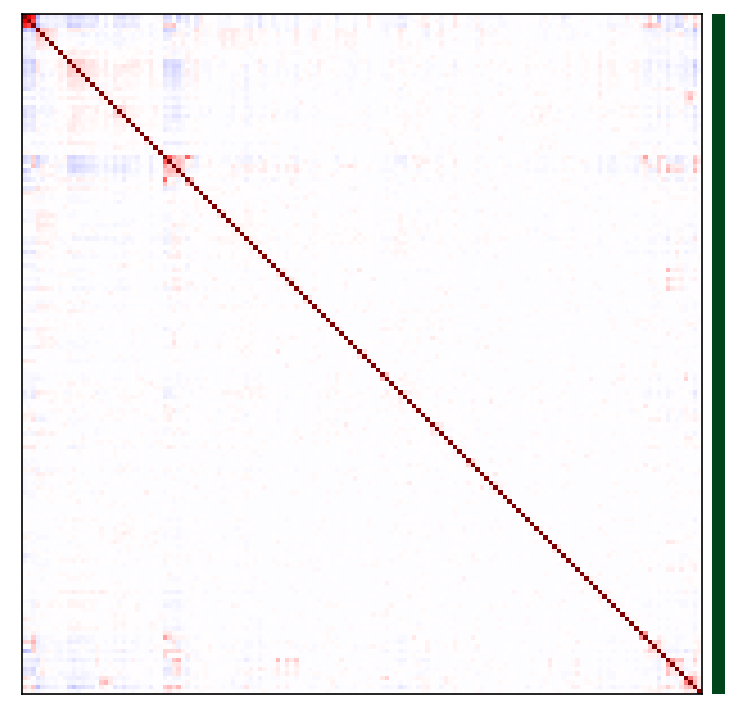

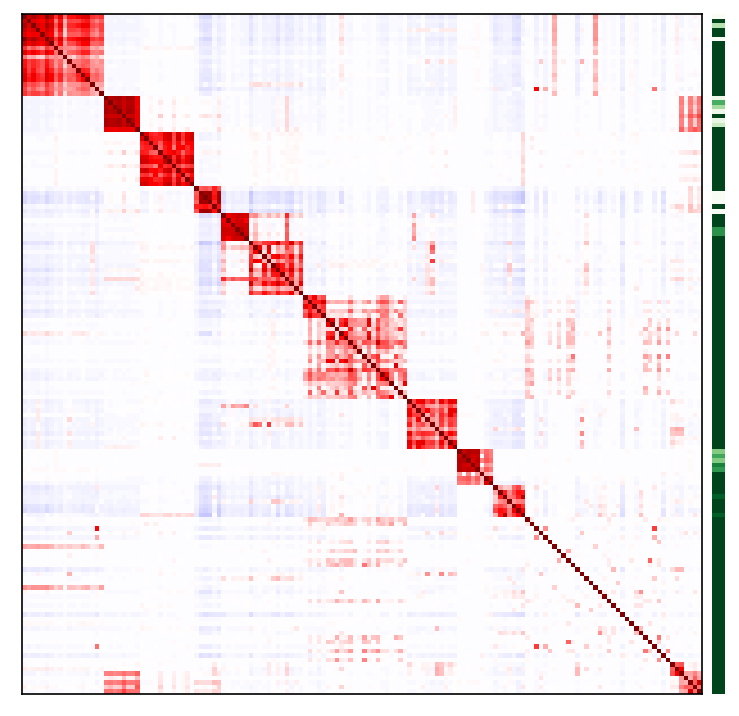

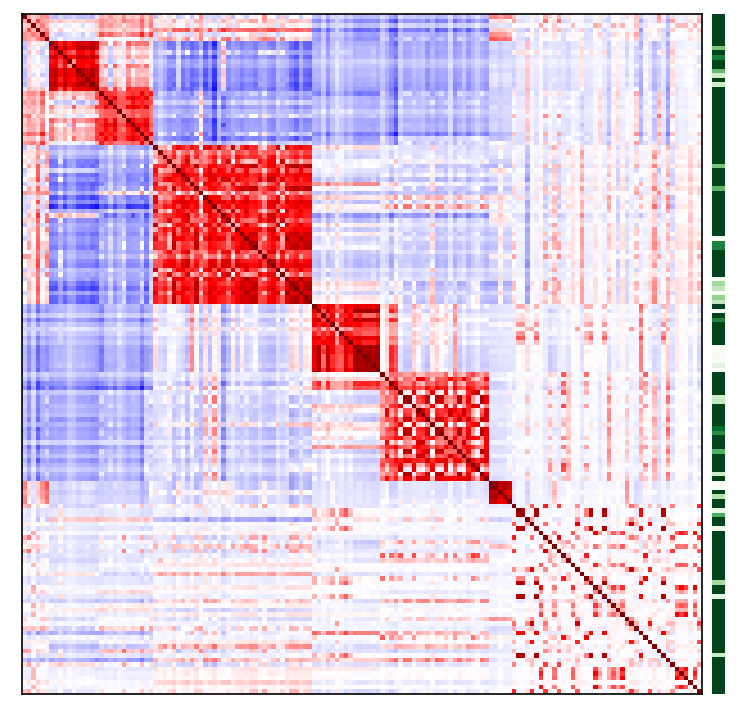

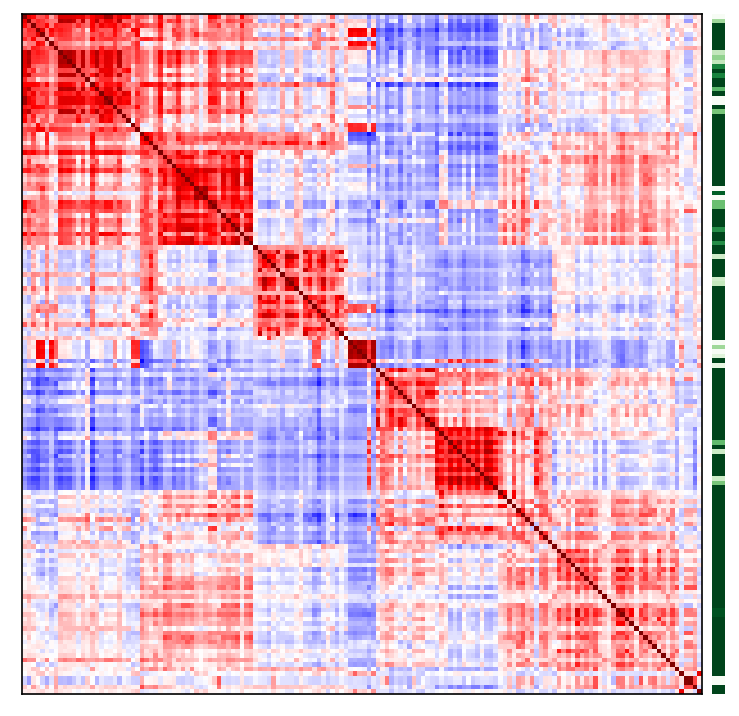

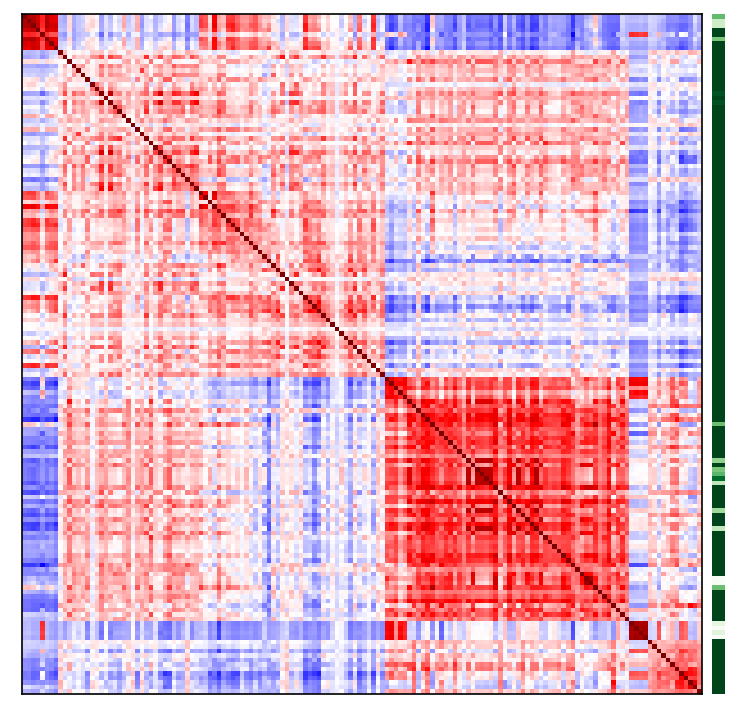

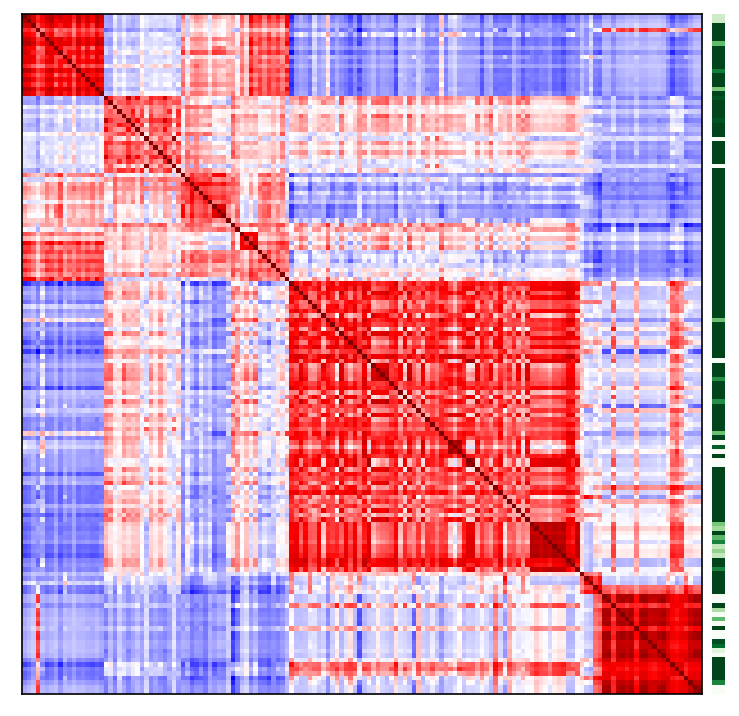

In [217]:
SMALL_SIZE =   5  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
################
for set_id, method in set_info["method"].items():
    df = gene_corr[set_id].copy()    
    
    ncols_perc = 3
    ncols = len(df.columns) + ncols_perc
    
        
    fig = plt.figure(figsize=(6*(ncols/len(df.columns)), 6 ))#(8,8))
    ax1 = plt.subplot2grid((1,ncols), (0,0), colspan=ncols-ncols_perc, rowspan=1)
    ax2 = plt.subplot2grid((1,ncols), (0,ncols-ncols_perc), colspan=ncols_perc, rowspan=1)
            
    # Heatmap plots
    ax1.imshow(df,cmap="seismic",vmin=-1,vmax=1)
    #ax2.imshow(df.max(axis=1).values[:,np.newaxis])
    #sns.heatmap(df.max(axis=1).values[:,np.newaxis],ax=ax2)
    sns.heatmap(thresholded_correlation(df, threshold=0.8, tolerance=0.05)[:,np.newaxis],ax=ax2,cmap="Greens",vmin=0,vmax=1,cbar=False)
        
    for ax in [ax1,ax2]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    
    fig.savefig(f"./figures/Suppl_gene_corr_n{n}_{method}.png", bbox_inches="tight", transparent=True)
    plt.show()    

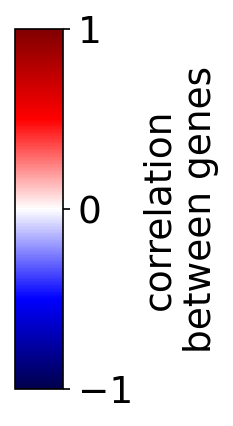

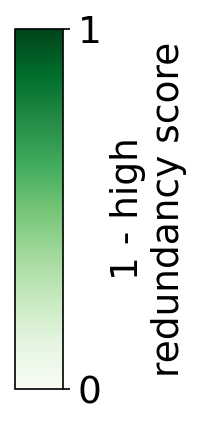

In [239]:
labelsize=18

a = np.array([[-1,1]])
plt.figure(figsize=(0.4, 4))
img = plt.imshow(a, cmap="seismic")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cb = plt.colorbar(orientation="vertical", cax=cax) #"vertical", "horizontal"
cb.set_ticks([-1,0,1])
cb.ax.tick_params(labelsize=labelsize)
cb.ax.set_ylabel('correlation\nbetween genes',fontsize=labelsize)
plt.savefig(f"./figures/Suppl_gene_corr_cbar1.png", bbox_inches="tight", transparent=True)
plt.show()

a = np.array([[0,1]])
plt.figure(figsize=(0.4, 4))
img = plt.imshow(a, cmap="Greens")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cb = plt.colorbar(orientation="vertical", cax=cax) #"vertical", "horizontal"
cb.set_ticks([0,1])
cb.ax.tick_params(labelsize=labelsize)
cb.ax.set_ylabel('1 - high\nredundancy score',fontsize=labelsize)
plt.savefig(f"./figures/Suppl_gene_corr_cbar2.png", bbox_inches="tight", transparent=True)
plt.show()